In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree


In [315]:
costa_rica = pd.read_csv("../final_data")
costa_rica = costa_rica.drop(columns = ["Id", "idhogar"])
costa_rica

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,Target,num_dis,avg_dis,avg_escolari,min_escolari,max_escolari,avg_behind_school,min_behind_school,max_behind_school
0,190000.00,0,3,0,1,1,0,NaN,0,1,...,43,4,0,0.00,10.00,10,10,NaN,NaN,NaN
1,135000.00,0,4,0,1,1,1,1.00,0,1,...,67,4,0,0.00,12.00,12,12,NaN,NaN,NaN
2,NaN,0,8,0,1,1,0,NaN,0,0,...,92,4,1,1.00,11.00,11,11,NaN,NaN,NaN
3,180000.00,0,5,0,1,1,1,1.00,0,2,...,38,4,0,0.00,8.25,2,11,0.50,0.00,1.00
4,130000.00,1,2,0,1,1,0,NaN,0,1,...,30,4,0,0.00,5.75,0,11,0.50,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,NaN,0,4,0,1,0,0,NaN,1,1,...,26,1,0,0.00,1.80,0,5,1.00,1.00,1.00
2969,NaN,0,3,0,0,0,0,NaN,2,2,...,40,2,2,0.40,3.40,0,6,0.00,0.00,0.00
2970,46500.00,0,5,0,1,1,0,NaN,1,2,...,45,4,0,0.00,6.00,0,11,NaN,NaN,NaN
2971,NaN,0,3,0,1,1,0,NaN,0,1,...,67,2,0,0.00,3.00,0,6,NaN,NaN,NaN


In [316]:
# Split data into train, validation, and test sets with 70/10/20 split
train, test = train_test_split(costa_rica, test_size=0.3, random_state = 0)
valid, test = train_test_split(test, test_size=0.1, random_state = 0)
x_train = train.drop(columns = ["Target"])
y_train = train["Target"]
x_test = test.drop(columns = ["Target"])
y_test = test["Target"]
x_valid = valid.drop(columns = ["Target"])
y_valid = valid["Target"]

In [317]:
# Use variance threshold to find most important features
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(x_train)
selected_features = sel.get_feature_names_out(x_train.columns)

In [318]:
# Drop unwanted features
x_train = x_train[selected_features]
x_valid = x_valid[selected_features]
x_test = x_test[selected_features]

In [319]:
# Impute missing values
imputer = KNNImputer()
x_train = pd.DataFrame(imputer.fit_transform(x_train), columns=imputer.get_feature_names_out())
x_valid = pd.DataFrame(imputer.fit_transform(x_valid), columns=imputer.get_feature_names_out())

**K-Nearest Neighbors Classifier**

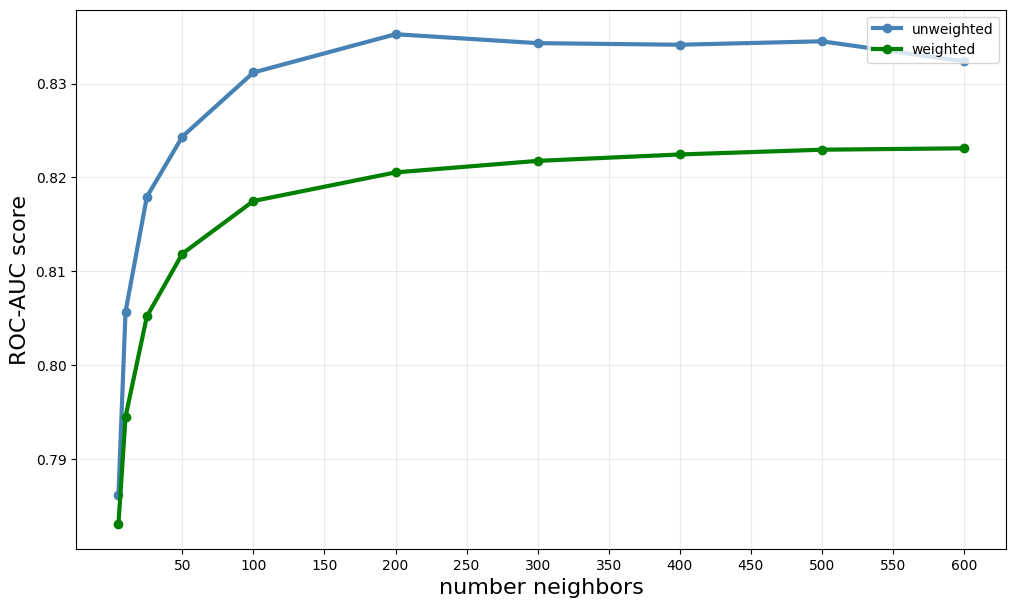

In [320]:
allks= [5,10,25,50,100,200,300, 400, 500, 600]
uw_scores = []
w_scores = []

# Unweighted
for k in allks:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(x_train, y_train)
    y_pred = knn.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    uw_scores.append(score)

# Weighted
for k in allks:
    knn = KNeighborsClassifier(n_neighbors = k, weights = "distance")
    knn.fit(x_train, y_train)
    y_pred = knn.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    w_scores.append(score)

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
ax.plot(allks, uw_scores, marker="o", color="steelblue", lw=3, label="unweighted")
ax.plot(allks, w_scores, marker="o", color="green", lw=3, label="weighted")
ax.set_xlabel("number neighbors", fontsize=16)
ax.set_ylabel("ROC-AUC score", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(50, 601, 50))
ax.grid(alpha=0.25)

**Decision Tree**

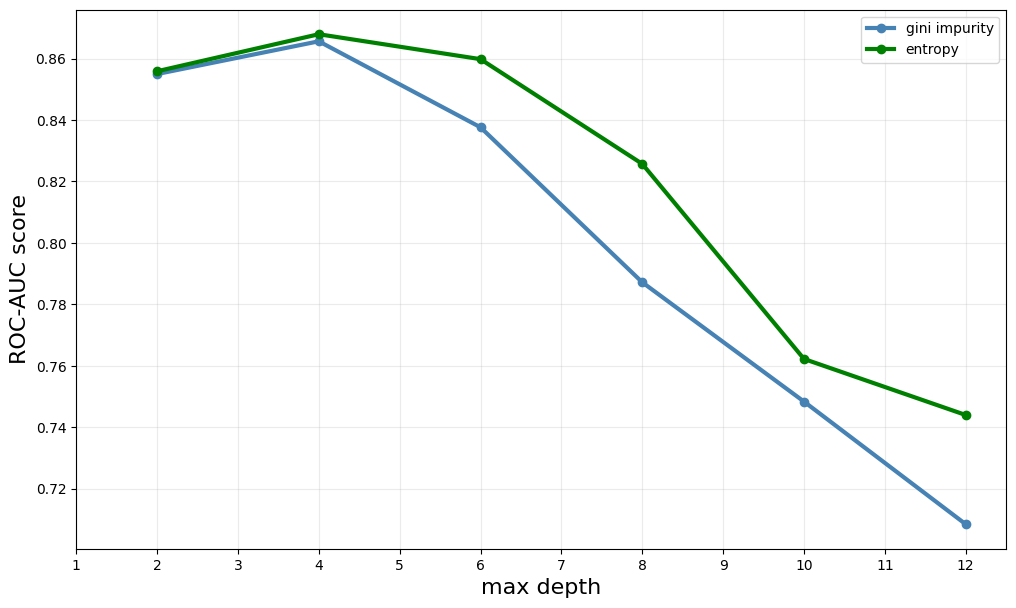

In [321]:
max_depths = [2, 4, 6, 8, 10, 12]
gini_score = []
entropy_score = []
gini_trees = {}
entropy_trees = {}

for d in max_depths:
    t = tree.DecisionTreeClassifier(criterion="gini", max_depth = d, random_state = 0)
    t.fit(x_train, y_train)
    y_pred = t.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    gini_score.append(score)
    gini_trees[d] = (t, score)

for d in max_depths:
    t = tree.DecisionTreeClassifier(criterion="entropy", max_depth = d, random_state = 0)
    t.fit(x_train, y_train)
    y_pred = t.predict_proba(x_valid)
    score = roc_auc_score(y_valid, y_pred, multi_class = "ovr", average = "micro")
    entropy_score.append(score)
    entropy_trees[d] = (t, score)

    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
ax.plot(max_depths, gini_score, marker="o", color="steelblue", lw=3, label="gini impurity")
ax.plot(max_depths, entropy_score, marker="o", color="green", lw=3, label="entropy")
ax.set_xlabel("max depth", fontsize=16)
ax.set_ylabel("ROC-AUC score", fontsize=16)
ax.legend(loc="upper right")
plt.xticks(range(1, 13, 1))
ax.grid(alpha=0.25)

In [322]:
# Best model is tree with max depth 4 using entropy to split
best_tree = entropy_trees[4][0]
best_score = entropy_trees[4][1]
print(best_score)

0.8679288893311194


feature: v2a1, importance: 0.0
feature: hacdor, importance: 0.0
feature: rooms, importance: 0.0
feature: hacapo, importance: 0.0
feature: v14a, importance: 0.0
feature: refrig, importance: 0.0
feature: v18q, importance: 0.02058565080771469
feature: v18q1, importance: 0.0
feature: r4h1, importance: 0.0
feature: r4h2, importance: 0.0
feature: r4h3, importance: 0.0
feature: r4m1, importance: 0.029584536109167222
feature: r4m2, importance: 0.0
feature: r4m3, importance: 0.0
feature: r4t1, importance: 0.0
feature: r4t2, importance: 0.0
feature: r4t3, importance: 0.0
feature: tamviv, importance: 0.02758659653853519
feature: escolari, importance: 0.0
feature: rez_esc, importance: 0.0
feature: paredblolad, importance: 0.0
feature: paredzocalo, importance: 0.0
feature: paredpreb, importance: 0.0
feature: pareddes, importance: 0.0
feature: paredmad, importance: 0.0
feature: paredzinc, importance: 0.0
feature: paredfibras, importance: 0.026483307272202716
feature: paredother, importance: 0.0
feat

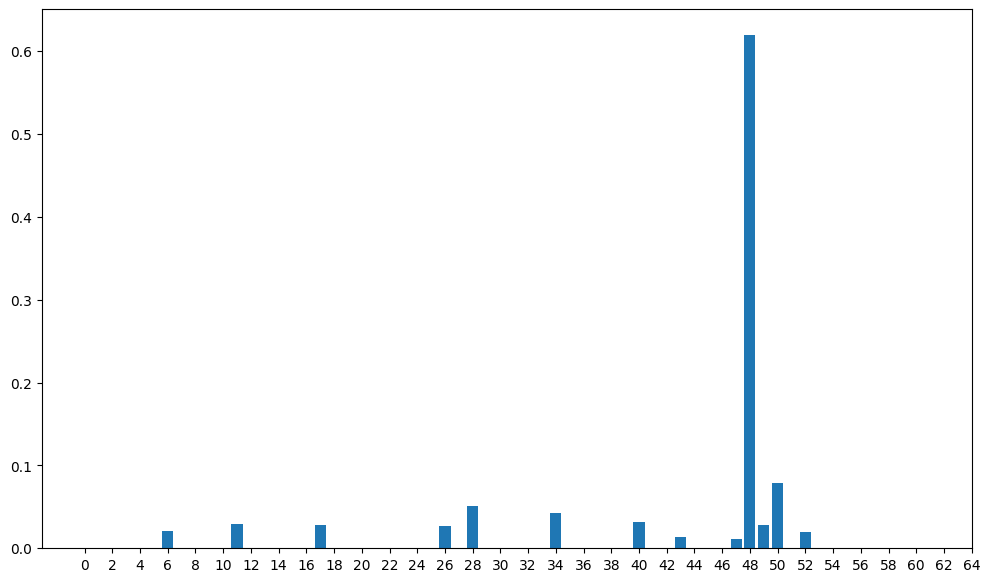

In [323]:
feature_importance = best_tree.feature_importances_
for feat, importance in zip(costa_rica.columns, feature_importance):
    print("feature: {f}, importance: {i}".format(f=feat, i=importance))

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12, 7))
plt.bar([x for x in range(len(feature_importance))], feature_importance)
plt.xticks(range(0, 65, 2))
plt.show()

In [324]:
print(costa_rica.columns[48])

sanitario3


r4t1, persons younger than 12 years of age
hogar_nin, Number of children 0 to 19 in household
meaneduc,average years of education for adults (18+)
qmobilephone, # of mobile phones
SQBmeaned, square of the mean years of education of adults (>=18) in the household